## 4 加载已训练模型进行预测

In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
IMAGE_SIZE = 32
NUM_LABELS = 10
num_channels = 1 # grayscale

In [3]:
BATCH_SIZE = 1
PATCH_SIZE = 5
DEPTH_1 = 16
DEPTH_2 = 32
DEPTH_3 = 64
NUM_HIDDEN = 128
SEED = 42

### 构建计算图

计算图需要与`capstone_single3_CNN`完全相同，否则无法加载保存的参数。

In [12]:
graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, num_channels))
    tf_train_labels = tf.placeholder(tf.int64, shape=(None,))
    
    conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, num_channels, DEPTH_1], stddev=0.1))
    conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
    conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
    conv2_biases = tf.Variable(tf.zeros([DEPTH_2]))
    conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
    conv3_biases = tf.Variable(tf.zeros([DEPTH_3]))
    fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE//8 * IMAGE_SIZE//8 * DEPTH_3, NUM_HIDDEN], stddev=0.1))
    fc1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]))
    fc2_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1))
    fc2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    saver = tf.train.Saver(tf.trainable_variables()) # defaults to saving all variables
    
    def model(data, train=False):
        conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv3_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [-1, shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        if train:
            hidden = tf.nn.dropout(hidden, 0.8, seed=SEED)
        return tf.matmul(hidden, fc2_weights) + fc2_biases
    
    logits = model(tf_train_dataset, True)
    prediction = tf.nn.softmax(logits)
    pred_class = tf.arg_max(prediction, 1)

In [5]:
def gcn(dataset):
    """Global contrast normalization"""
    mean = dataset.mean(axis=(1,2))
    std = dataset.std(axis=(1,2))
    return (dataset - mean[:, None, None]) / std[:, None, None]

### 计算测试集分类准确率

In [6]:
pickle_file = 'svhn_single.pickle'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    test_dataset = dataset['test_dataset']
    test_labels = dataset['test_labels']
    del dataset
    
print('Testing dataset shape: ', test_dataset.shape)
print('Testing labels shape: ', test_labels.shape)

Testing dataset shape:  (26032, 32, 32)
Testing labels shape:  (26032,)


注意事项：

- 一次性输入全部测试集数据，Python会因为GPU存储不够而崩溃。
- 因此，计算测试集分类准确率的时候也需要分批计算，同时将预测的结果保存到array中。
- 下面借助Python生成器对数据进行分批。

In [7]:
test_batch_size = 100

In [27]:
def next_batch(data, labels, batch_size):
    # 借助Python生成器对数据进行分批。
    for i in range((data.shape[0] + batch_size - 1) // batch_size):
        yield data[i*batch_size:(i+1)*batch_size], labels[i*batch_size:(i+1)*batch_size]

In [28]:
predictions = np.zeros(test_labels.shape, dtype=np.int32)

In [29]:
batches = next_batch(test_dataset.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1), test_labels, test_batch_size)

In [37]:
with tf.Session(graph=graph) as session:
    saver.restore(session, 'single.ckpt')
    for i, batch in enumerate(batches):
        feed_dict = {tf_train_dataset: batch[0], tf_train_labels: batch[1]}
        predictions[i*test_batch_size:(i+1)*test_batch_size] = session.run(pred_class, feed_dict=feed_dict)

In [38]:
def accuracy(predictions, labels):
    return np.mean(predictions == labels)

In [43]:
test_labels[test_labels==10] = 0

In [44]:
accuracy(predictions, test_labels)

0.91952212661339894

In [45]:
predictions[:100]

array([5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, 4, 1, 6, 3, 4, 2, 0, 1,
       9, 2, 5, 4, 1, 4, 2, 9, 3, 8, 6, 0, 1, 5, 1, 1, 2, 9, 1, 6, 9, 4, 6,
       1, 2, 0, 6, 9, 1, 5, 1, 9, 6, 4, 5, 1, 5, 9, 9, 2, 4, 1, 0, 6, 9, 3,
       2, 3, 5, 1, 1, 4, 6, 2, 8, 3, 1, 4, 1, 7, 1, 2, 1, 7, 1, 0, 1, 4, 4,
       6, 4, 4, 2, 2, 1, 7, 7], dtype=int32)

In [46]:
test_labels[:100]

array([5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, 4, 1, 6, 3, 4, 2, 0, 1,
       3, 2, 5, 4, 1, 4, 2, 8, 3, 8, 6, 0, 1, 5, 1, 1, 2, 9, 1, 6, 9, 2, 6,
       1, 2, 0, 6, 9, 1, 5, 1, 9, 8, 1, 5, 1, 5, 2, 9, 2, 4, 1, 0, 6, 9, 3,
       2, 3, 5, 1, 1, 4, 6, 2, 8, 3, 1, 4, 1, 7, 1, 2, 1, 7, 1, 0, 1, 4, 4,
       6, 4, 4, 2, 8, 1, 7, 7], dtype=uint8)

### 计算混淆矩阵

混淆矩阵能够显示模型所犯的不同种类的错误。每一行左侧标签代表真实样本的类别，每一列下侧标签代表神经网络预测的类别，比如第2行第3列代表真实为2预测成为3。混淆矩阵对角线上的单元代表正确预测的情况。

In [47]:
from sklearn.metrics import confusion_matrix

In [49]:
cm = confusion_matrix(test_labels, predictions)

In [50]:
cm

array([[1604,   20,   10,    9,    0,    4,   31,    3,   25,   38],
       [  24, 4886,   25,   27,   34,    9,   15,   50,   21,    8],
       [   6,   35, 3893,   68,   19,   22,   13,   54,   14,   25],
       [  11,   47,   30, 2578,    9,   57,   16,   13,   45,   76],
       [  13,  109,   31,   20, 2286,    9,   15,   16,   11,   13],
       [   7,   12,    9,   98,   11, 2155,   45,   11,   16,   20],
       [  32,   19,    7,   15,    7,   50, 1778,    2,   58,    9],
       [   5,   89,   24,   14,    6,    9,    5, 1862,    2,    3],
       [  18,   14,   19,   33,   10,   10,   65,    2, 1451,   38],
       [  31,   14,   34,   15,    8,   12,    5,    6,   26, 1444]])

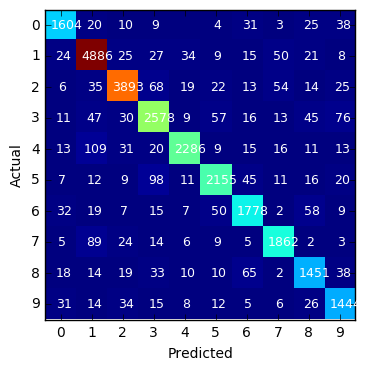

In [54]:
thresh = cm.max() / 2.
       
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()

for i, cas in enumerate(cm):
    for j, count in enumerate(cas):
        xoff = .085 * len(str(count))
        plt.text(j-xoff, i+.1, int(count), fontsize=12, color="white" if cm[i, j] > thresh else "black")

### 展示预测错误的图片

In [60]:
predict_wrong = predictions != test_labels
predict_correct = predictions == test_labels

In [56]:
def plot_images(images, labels):
    fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(6,5))
    #fig.subplots_adjust(hspace=0.3, wspace=0.1)
    for i, ax in enumerate(axes.flatten()):
        ax.axis('off')
        ax.imshow(images[i], cmap=plt.cm.gray, interpolation='none')
        ax.set_title( str(labels[i]) )

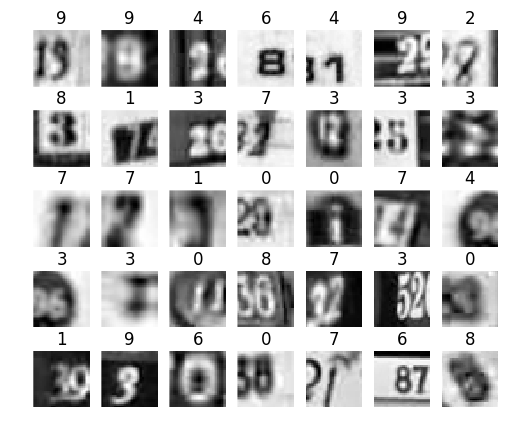

In [59]:
plot_images(test_dataset[predict_wrong], predictions[predict_wrong])

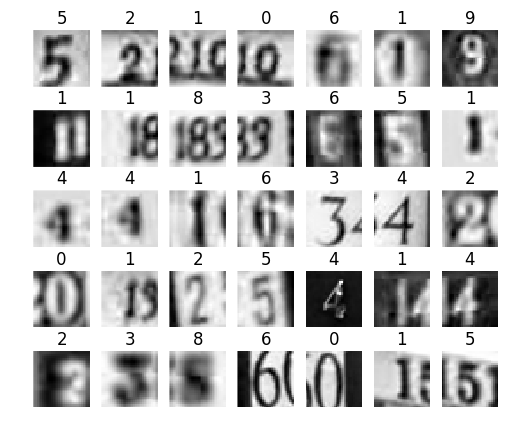

In [61]:
plot_images(test_dataset[predict_correct], predictions[predict_correct])

### 单张图片的分类

In [95]:
image = plt.imread('test-3-2.png')
image = image.mean(axis=2)
test_dataset = image.reshape((-1, 32, 32, 1))
test_dataset.shape

(1, 32, 32, 1)

In [96]:
test_dataset.shape

(1, 32, 32, 1)

In [97]:
test_dataset = gcn(test_dataset)

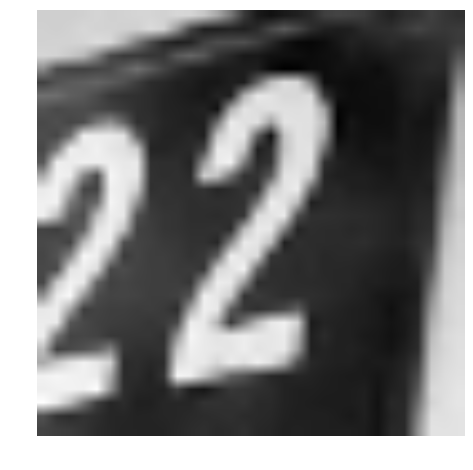

In [98]:
plt.axis('off')
plt.imshow(test_dataset[0].reshape((32,32)), cmap=plt.cm.gray)

In [99]:
with tf.Session(graph=graph) as session:
    saver.restore(session, 'single.ckpt')
    test_prediction = train_prediction.eval(feed_dict={tf_train_dataset: test_dataset})

In [100]:
test_prediction[0]

array([  4.46757156e-38,   0.00000000e+00,   1.00000000e+00,
         3.86693706e-30,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.19625181e-38,   5.72687271e-32,
         0.00000000e+00], dtype=float32)

In [101]:
import seaborn

<Container object of 10 artists>

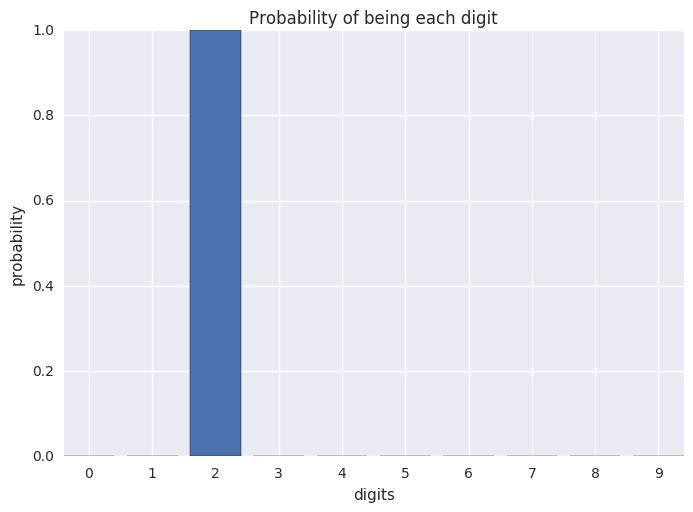

In [102]:
plt.title('Probability of being each digit')
plt.xticks(np.arange(10)+0.4, np.arange(10))
plt.ylabel('probability')
plt.xlabel('digits')
plt.bar(np.arange(10), test_prediction[0])